### Introduction

This assignment will have you implementing value iteration, policy evaluation and policy iteration.

In [1]:
import gymnasium as gym
import numpy as np

We will be playing on the 
Taxi environment. The environment is loaded as follows:

In [2]:
taxi_env = gym.make('Taxi-v3')
starting_state = taxi_env.reset() #must reset the environment before interacting with it

The Taxi domain was introduced in the paper "The MAXQ Method for Hierarchical Reinforcement Learning" by Thomas G. Dietterich (https://pdfs.semanticscholar.org/fdc7/c1e10d935e4b648a32938f13368906864ab3.pdf) in ICML 1998. 

The version that we will be playing is slightly simpler than the version considered in that paper. Here is a description from the open source code for gym:

> Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

> Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 

    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi

    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

In order to apply the model-based method in the episodic setting, we add a terminal state (the taxi drops off the passenger at the destination) in the MDP. So we end up with 501 states in total. We provide you with an MDP class for modelling the environment. You can directly use it for all the following questions.

In [3]:
class MDP:
  def __init__(self,env):
    self.num_states = env.observation_space.n + 1
    self.num_actions = env.action_space.n
    self.starting_state = starting_state
    self.action_to_plot = 1

    self.R = np.zeros([self.num_states, self.num_actions])
    self.T = np.zeros([self.num_states, self.num_actions, self.num_states])
    self.gamma = 0.99

    for state in range(self.num_states - 1):
      for action in range(self.num_actions):
          for transition in env.unwrapped.P[state][action]:
              probability, next_state, reward, done = transition
              self.R[state, action] = reward
              self.T[state, action, next_state] = probability

    for action in range(self.num_actions):
      self.T[-1, action, -1] = 1

    for state in range(self.num_states - 1):
      state_decode = list(env.unwrapped.decode(state))
      des_x = taxi_env.unwrapped.locs[state_decode[3]][0]
      des_y = taxi_env.unwrapped.locs[state_decode[3]][1]
      if (state_decode[2] == 4) and (state_decode[0] == des_x) and (state_decode[1] == des_y):
        self.T[state, 5] = 0
        self.T[state, 5, -1] = 1

  def reset(self):
    env.reset()

The MDP for Taxi is created as follows:

In [4]:
taxi_env.reset()
taxi_mdp = MDP(taxi_env)
#attributes of the MDP:
print(taxi_mdp.num_states) #number of states
print(taxi_mdp.num_actions) #number of actions
print(taxi_mdp.gamma) #gamma 
print(taxi_mdp.R.shape) #reward matrix (dimension num_states X num_actions)
print(taxi_mdp.T.shape) #transition matrix (dimension num_states x num_actions X num_states)


501
6
0.99
(501, 6)
(501, 6, 501)


### Question 1: Implement the Value Iteration algorithm and solve for $Q^\star$.

Write a method called value_iter(mdp) which takes an MDP as argument and returns the optimal Q-value function ($Q^\star$) as a np.array with $501\times 6$ elements (the number of states $\times$ the number of actions). Do this by implementing the Value Iteration algorithm seen in class, a.k.a. by repeatedly applying the Bellman operator $\mathcal{T}$. Run your code on the taxi environment and output the optimal Q-value function. As a stopping criterion, you can check if $\lVert Q_n - Q_{n+1}\rVert_\infty < 10^{-4}$. Plot a 'learning curve' which consists of the optimal Q-value function for the (starting state, action_to_plot) pair at each iteration of training. More specifically, your plot should have the iteration number on the $x$-axis and $Q(\texttt{starting\_state, action\_to\_plot})$ on the $y$-axis. In value_iter function, you can also return other variables that are useful for your plot (e.g. training values) as long as you return the final Q_fn. 

In the code above, starting_state is defined by starting_state = taxi_env.reset(), and action_to_plot is set to 1. In your implementation, you only need to use those variables defined in the MDP class (i.e. mdp.starting_state[0], mdp.action_to_plot).

You should expect that the Q-value function of any (state, action) pair does not exceed 20 no matter how you choose $\gamma$ (we provide mdp.gamma=0.99, but you can also try other values).

Q-Value iteration converged after 19 number of iterations
Returned Q function: [[16.43588    17.612      16.43588    17.612      18.8         8.612     ]
 [ 7.44059051  8.525849    7.44059051  8.525849    9.6220697  -0.474151  ]
 [11.84784175 12.97761793 11.84784175 12.97761793 14.11880599  3.97761793]
 ...
 [ 9.6220697  10.72936333  9.6220697  10.72936333  0.6220697   0.6220697 ]
 [17.612      16.43588    17.612      18.8         8.612       8.612     ]
 [ 0.          0.          0.          0.          0.          0.        ]]


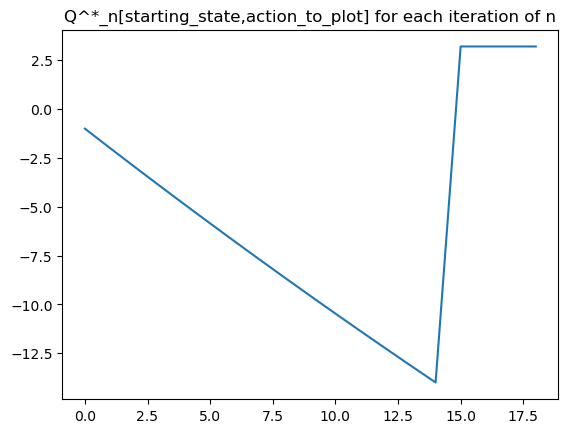

In [29]:
#solution
def value_iter(mdp):
  T = mdp.T
  R = mdp.R
  num_states = mdp.num_states
  num_actions = mdp.num_actions
  gamma = mdp.gamma
  starting_state = mdp.starting_state
  action_to_plot = mdp.action_to_plot 

  Q_fn = np.zeros([num_states, num_actions])
  # max_iterations = 1000
  delta = 10**-4
  iters = 0
  Q_list = []
  while True:
      previous_Q_fn = Q_fn.copy()
      previous_value_fn = np.max(previous_Q_fn, axis=1)
      Q_fn = R + gamma * np.einsum('ijk,k', T, previous_value_fn)
      if np.max(np.abs(Q_fn - previous_Q_fn)) < delta:
              break

      iters += 1
      Q_list.append(Q_fn[starting_state[0], action_to_plot])
      #print(Q_list[-1])
      #print(Q_fn)
  print("Q-Value iteration converged after " + str(iters) + " number of iterations")
  return Q_fn, Q_list

Q_fn, values = value_iter(taxi_mdp)

import matplotlib.pyplot as mpl

print('Returned Q function:', Q_fn)
#print(values)
mpl.plot(values)
mpl.title('Q^*_n[starting_state,action_to_plot] for each iteration of n')
mpl.show()

### Question 2: Implement the Policy Evaluation algorithm and solve for the Q-value function $Q^\pi$ of a given policy $\pi$.

Write a method called policy_eval(mdp, policy) which takes an MDP and a policy and then outputs the Q-value function $Q^\pi$ (for the input policy in the input MDP) as a np.array with $501\times 6$ elements. Do this by implementing the Policy Evaluation algorithm seen in class, a.k.a. by repeatedly applying the Bellman operator $\mathcal{T}^\pi$. You should not assume the policy is deterministic. The format of the policy $\pi(a|s)$ is a (num_states)$\times$(num_actions) array (i.e. 501$\times$6). Every row of the policy matrix should be a probability distribution over actions. Run your code on the taxi environment with the policy which acts uniformly at random at every state. Plot a 'learning curve' which consists of the Q-value function for the (starting_state, action_to_plot) pair (i.e. $Q(\texttt{starting\_state, action\_to\_plot})$) at each iteration of training. In policy_eval function, you can also return other variables that are helpful for your plot (e.g. training values) as long as you return the final Q_fn.

Returned Q function: [[-268.61579952 -216.70008237 -253.40535188 -216.70008237 -126.15197518
  -225.70008237]
 [-369.76644695 -358.75674682 -366.54079567 -358.75674682 -346.64565837
  -367.75674682]
 [-358.25466717 -342.58959319 -353.66506627 -342.58959319 -321.551861
  -351.58959319]
 ...
 [-363.08522697 -362.16885077 -363.08522697 -361.94666507 -372.08522697
  -372.08522697]
 [-183.30685331 -225.5268433  -183.30685331 -128.13592271 -192.30685331
  -192.30685331]
 [   0.            0.            0.            0.            0.
     0.        ]]


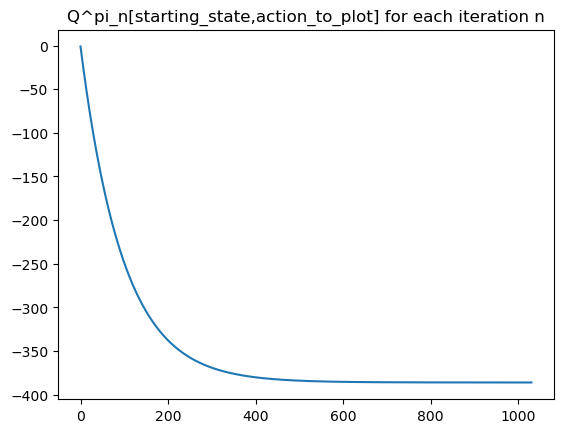

In [32]:
#solution
def policy_eval(mdp, policy):
  T = mdp.T
  R = mdp.R
  num_states = mdp.num_states
  num_actions = mdp.num_actions
  gamma = mdp.gamma 
  starting_state = mdp.starting_state
  action_to_plot = mdp.action_to_plot
  
  Q_fn = np.zeros([num_states, num_actions])
  delta = 10**-4
  iters=0
  Q_list = []
  while True:
    previous_Q_fn = Q_fn.copy()
    previous_value_fn = np.einsum('ij, ij->i', policy, previous_Q_fn)
    Q_fn = R + gamma * np.einsum('ijk, k', T, previous_value_fn)
    if np.max(np.abs(Q_fn - previous_Q_fn)) < delta:
      break
    iters += 1
    Q_list.append(Q_fn[starting_state[0], action_to_plot])
    #print(Q_list[-1])
  return Q_fn, Q_list

policy_unif = 1./6.*np.ones([taxi_mdp.num_states,taxi_mdp.num_actions])
Q_fn, values = policy_eval(taxi_mdp,policy_unif)

import matplotlib.pyplot as mpl

print('Returned Q function:', Q_fn)
mpl.plot(values)
mpl.title('Q^pi_n[starting_state,action_to_plot] for each iteration n')
mpl.show()

### Question 3: Implement Policy Iteration using your solution from Q2 as a sub-routine, and solve for the optimal policy $\pi^\star$.

Write a method called policy_iteration(mdp,policy) which takes an MDP and an *initial* policy, and outputs the optimal policy $\pi^\star$ via successive rounds of policy improvement.  The method should return the policy obtained, as a $501\times 6$ np.array. Run your code on the taxi environment with the policy which acts uniformly at random at every state as a starting policy. Plot a 'learning curve' which consists of the state-value function for the starting state (i.e. mdp.starting_state) for each policy obtained. You can check if/that the optimal value obtained from policy iteration is the same (or close to) the value function obtained from value iteration. You can also return other variables that is useful for your plot (e.g. training values) as long as you return the final policy. 

You should expect the results are exactly or almost the same in policy iteration and value iteration. Notice that we get Q-value function in value_iter function, and obtain state-value function in policy_iter function. If you want to compare the results, you need to have additional step for the coversion.

Policy-Iteration converged at step 2.


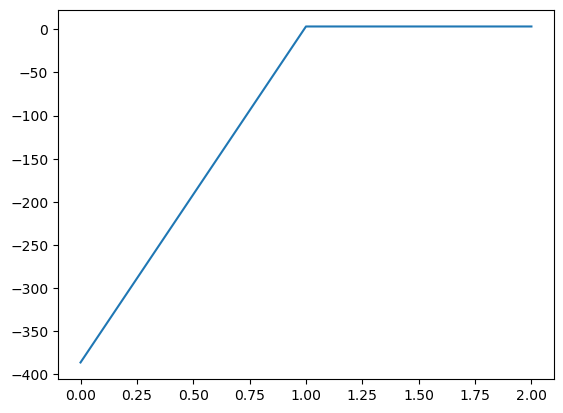

Q-Value iteration converged after 19 number of iterations
Checking that value iteration == policy iteration
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

In [33]:
#function to compute the greedy policy of a value function. need not be part of the homework
def greedy_policy(mdp, value_fn):
    num_states = mdp.num_states
    num_actions = mdp.num_actions
    R = mdp.R
    T = mdp.T
    gamma = mdp.gamma
    policy = np.zeros((num_states,num_actions))
    Q = R + gamma * np.einsum('ijk,k', T, value_fn)
    for s in range(num_states):
      policy[s,np.argmax(Q[s,:])] = 1
    return policy
  
#solution  
def policy_iter(mdp,policy_init):
  import math
  policy = policy_init 
  num_states = mdp.num_states
  for s in range(num_states):
    assert(math.isclose(np.sum(policy[s,:]),1)) #check that policy is a distribution
  iters = 0
  values=[]
  while True:
    old_Q_fn = policy_eval(mdp, policy)[0]
    old_value_fn = np.max(old_Q_fn, axis=1)
    values.append(old_value_fn[mdp.starting_state[0]])
    new_policy = greedy_policy(mdp, old_value_fn)
    if (np.all(policy == new_policy)):
      print ('Policy-Iteration converged at step %d.' %(iters))
      break
    policy = new_policy.copy()
    iters += 1  
  return policy, values, old_value_fn

policy_unif = 1./6.*np.ones([taxi_mdp.num_states, taxi_mdp.num_actions])
policy, values_start_pi, values_pi = policy_iter(taxi_mdp, policy_unif)
mpl.plot(values_start_pi)
mpl.show('Policy iteration plot')
#print(values_start_pi)

Q_fn_vi, _ = value_iter(taxi_mdp)
value_fn_vi = np.max(Q_fn_vi, axis=1)

print('Checking that value iteration == policy iteration')
print(value_fn_vi - values_pi)